## Download Data

In [ ]:
!gdown --id 1tgXDvaT0gwZ0-Z0Dq5UijY-72_CL0APV
!gdown --id 1C-1SdIrvyd7EJ3qQQc3U79_NuCg32dfj
!gdown --id 1X7SP0BAFd2EIGEmbSEEqgqD1GinM8a4w


Downloading...
From: https://drive.google.com/uc?id=1tgXDvaT0gwZ0-Z0Dq5UijY-72_CL0APV
To: /media/aivn24/partition1/Khoa/CNN2/K_LHR_image.zip
100%|██████████████████████████████████████| 89.0M/89.0M [00:08<00:00, 10.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1C-1SdIrvyd7EJ3qQQc3U79_NuCg32dfj
To: /media/aivn24/partition1/Khoa/CNN2/traffic-signs-classification.zip
100%|██████████████████████████████████████| 72.0M/72.0M [00:07<00:00, 10.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1X7SP0BAFd2EIGEmbSEEqgqD1GinM8a4w
To: /media/aivn24/partition1/Khoa/CNN2/weather-dataset.zip
100%|████████████████████████████████████████| 615M/615M [00:59<00:00, 10.4MB/s]


## Import Modules

In [ ]:
import os 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
# from sklearn.model_selection import train_test_split

In [ ]:
# os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Ex1: Weather Recognition using VGG19

### Prepare Weather Data

#### Thống kê data

In [ ]:
!unzip -q -n /media/aivn24/partition1/Khoa/CNN2/weather-dataset.zip -d /media/aivn24/partition1/Khoa/CNN2/weather-dataset

In [ ]:
# list đường dẫn các file ảnh
WEATHER_DATA_PATH = '/media/aivn24/partition1/Khoa/CNN2/weather-dataset/dataset'
path_imgs = list(glob.glob(WEATHER_DATA_PATH+'/**/*.jpg'))


In [ ]:
# split đường dẫn các file để lấy label cho ảnh và tao thành dataframe để  thống kê
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path     Labels
0  /media/aivn24/partition1/Khoa/CNN2/weather-dat...  sandstorm
1  /media/aivn24/partition1/Khoa/CNN2/weather-dat...        dew
2  /media/aivn24/partition1/Khoa/CNN2/weather-dat...        dew
3  /media/aivn24/partition1/Khoa/CNN2/weather-dat...       hail
4  /media/aivn24/partition1/Khoa/CNN2/weather-dat...       hail

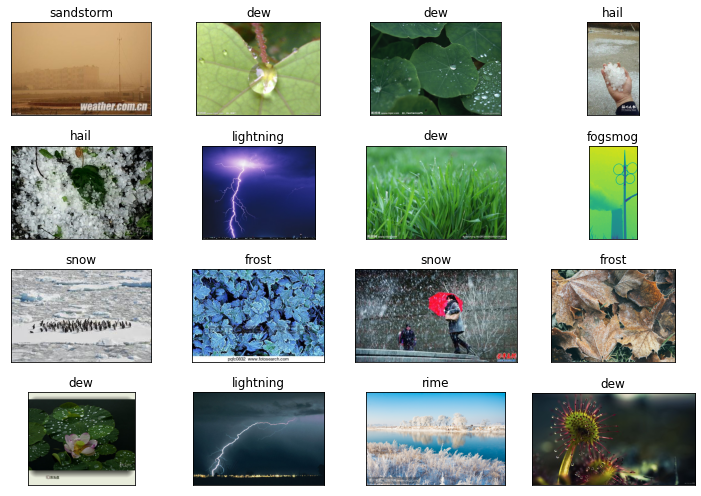

In [ ]:
# vẽ các ảnh tương ứng với label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

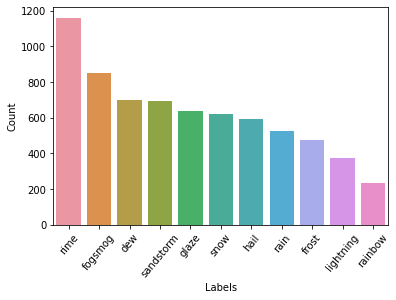

In [ ]:
# Thống kê số lượng ảnh cho từng label 
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

#### Split Tran Validation data

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


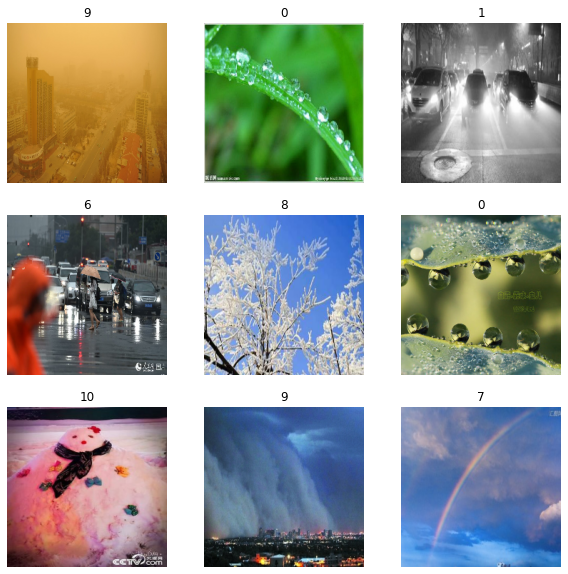

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.keras.applications.vgg19.preprocess_input(x)), 
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 7,  3,  9, 10, 10,  4,  1,  6,  0,  0,  8,  0,  8, 10,  3,  1,  8,
        2,  1,  0,  2,  2,  7,  6,  0,  9,  9,  5,  9, 10,  6,  0],
      dtype=int32)>

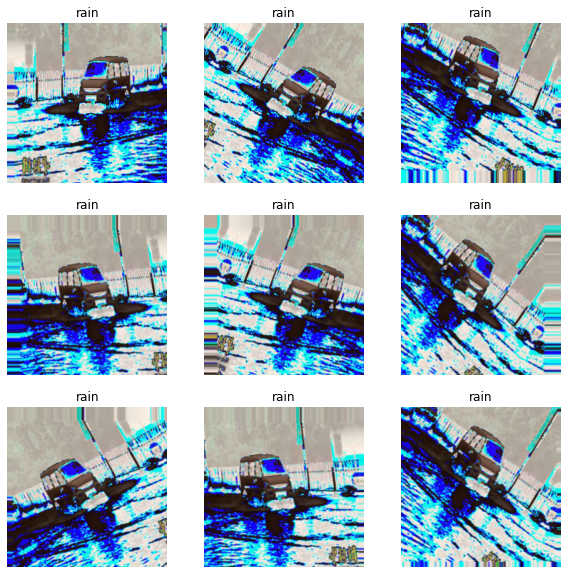

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

### Training

#### VGG19 Model

VGG19 Architecture
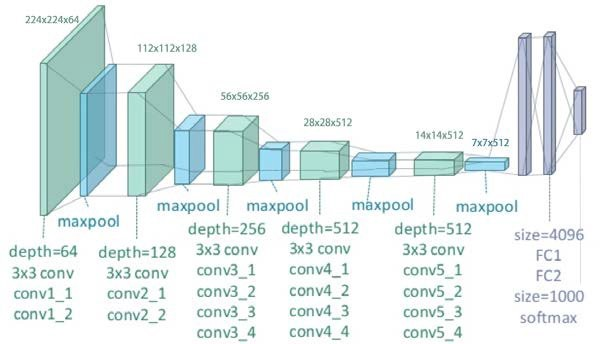

In [ ]:
def get_vgg19_model(num_classes):
    img_input = layers.Input(shape=(224,224,3))
    
    # Block 1
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(img_input)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 2
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 3
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 4
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 5
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Classification Block
    x = layers.Flatten()(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=num_classes, activation='softmax')(x)

    # VGG19 model
    mode = Model(inputs=img_input, outputs=x)

    return mode




In [ ]:
my_vgg19 = get_vgg19_model(num_classes=11)
my_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

#### Config and Compile Model

In [ ]:
image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = my_vgg19(x)

weather_model = Model(inputs=image_input, outputs=x)

In [ ]:
weather_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 11)                139615307 
                                                                 
Total params: 139,615,307
Trainable params: 139,615,307
Non-trainable params: 0
_________________________________________________________________


In [ ]:
weather_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [ ]:
num_epochs = 50

checkpoint_path = "/media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather.h5"
os.makedirs("/media/aivn24/partition1/Khoa/CNN2/save_model", exist_ok=True)
# os.makedirs
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 5, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)



history = weather_model.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/50
172/172 [==============================] - ETA: 0s - loss: 1.9231 - accuracy: 0.3521
Epoch 00001: val_accuracy improved from -inf to 0.39213, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather.h5
172/172 [==============================] - 36s 185ms/step - loss: 1.9231 - accuracy: 0.3521 - val_loss: 1.8194 - val_accuracy: 0.3921
Epoch 2/50
172/172 [==============================] - ETA: 0s - loss: 1.4613 - accuracy: 0.5175
Epoch 00002: val_accuracy improved from 0.39213 to 0.51895, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather.h5
172/172 [==============================] - 28s 165ms/step - loss: 1.4613 - accuracy: 0.5175 - val_loss: 1.3530 - val_accuracy: 0.5190
Epoch 3/50
172/172 [==============================] - ETA: 0s - loss: 1.2064 - accuracy: 0.5944
Epoch 00003: val_accuracy improved from 0.51895 to 0.58455, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather.h5
172/172 [======

172/172 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.8024
Epoch 00026: val_accuracy did not improve from 0.72668
172/172 [==============================] - 25s 145ms/step - loss: 0.5520 - accuracy: 0.8024 - val_loss: 0.9039 - val_accuracy: 0.7245
Epoch 27/50
172/172 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.8164
Epoch 00027: val_accuracy did not improve from 0.72668
172/172 [==============================] - 25s 145ms/step - loss: 0.5188 - accuracy: 0.8164 - val_loss: 0.9502 - val_accuracy: 0.7106
Epoch 28/50
172/172 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.8160
Epoch 00028: val_accuracy did not improve from 0.72668
172/172 [==============================] - 25s 146ms/step - loss: 0.5112 - accuracy: 0.8160 - val_loss: 0.8284 - val_accuracy: 0.7208
Epoch 29/50
172/172 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.8220
Epoch 00029: val_accuracy improved from 0.72668 to 0.7456

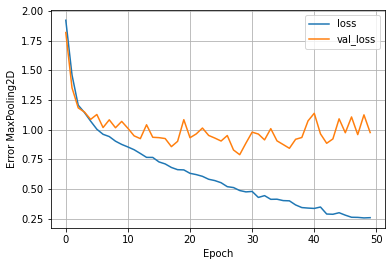

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error MaxPooling2D')
plt.legend()
plt.grid(True)

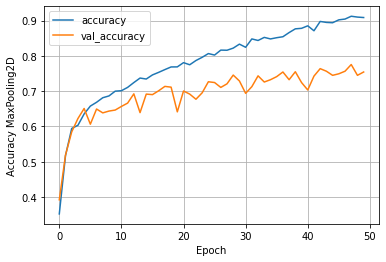

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy MaxPooling2D')
plt.legend()
plt.grid(True)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  accuracy  val_loss  val_accuracy  epoch
45  0.278261  0.902186  0.973748      0.749271     45
46  0.260630  0.904372  1.107031      0.756560     46
47  0.259566  0.912386  0.957966      0.775510     47
48  0.255083  0.910018  1.124738      0.744898     48
49  0.257167  0.908743  0.975331      0.754373     49

## Ex2: Weather Recognition using VGG19 with different downsample techniques:

### Prepare Weather Data

#### Split Tran Validation data

In [ ]:
WEATHER_DATA_PATH = '/media/aivn24/partition1/Khoa/CNN2/weather-dataset/dataset'

batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


#### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.keras.applications.vgg19.preprocess_input(x)), 
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 9,  0,  1,  6,  8,  0, 10,  9,  7,  0,  9,  1, 10,  4,  1,  4,  9,
       10,  6, 10,  8,  2,  3, 10,  8,  7,  0,  2,  5,  8,  6, 10],
      dtype=int32)>

### Training

#### Average Pooling

##### VGG19 Model with Custom Downsample Layer

In [ ]:
def get_vgg19_model_average_pooling(num_classes):
    img_input = layers.Input(shape=(224,224,3))
    
    # Block 1
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(img_input)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 2
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 3
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 4
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 5
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Classification Block
    x = layers.Flatten()(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=num_classes, activation='softmax')(x)

    # VGG19 model
    mode = Model(inputs=img_input, outputs=x)

    return mode




In [ ]:
my_vgg19_ave_pool = get_vgg19_model_average_pooling(num_classes=11)
my_vgg19_ave_pool.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 average_pooling2d (AverageP  (None, 112, 112, 64)     0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

##### Config and Compile Model

In [ ]:
image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = my_vgg19_ave_pool(x)

weather_model_ave_pool = Model(inputs=image_input, outputs=x)

In [ ]:
weather_model_ave_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 11)                139615307 
                                                                 
Total params: 139,615,307
Trainable params: 139,615,307
Non-trainable params: 0
_________________________________________________________________


In [ ]:
weather_model_ave_pool.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [ ]:
num_epochs = 50

checkpoint_path = "/media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_ave_pool_weather.h5"
os.makedirs("/media/aivn24/partition1/Khoa/CNN2/save_model", exist_ok=True)
# os.makedirs
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 5, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)



history = weather_model_ave_pool.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/50
172/172 [==============================] - ETA: 0s - loss: 1.9402 - accuracy: 0.3393
Epoch 00001: val_accuracy improved from -inf to 0.41254, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_ave_pool_weather.h5
172/172 [==============================] - 35s 178ms/step - loss: 1.9402 - accuracy: 0.3393 - val_loss: 1.8332 - val_accuracy: 0.4125
Epoch 2/50
172/172 [==============================] - ETA: 0s - loss: 1.6252 - accuracy: 0.4634
Epoch 00002: val_accuracy improved from 0.41254 to 0.50292, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_ave_pool_weather.h5
172/172 [==============================] - 27s 159ms/step - loss: 1.6252 - accuracy: 0.4634 - val_loss: 1.4268 - val_accuracy: 0.5029
Epoch 3/50
172/172 [==============================] - ETA: 0s - loss: 1.3347 - accuracy: 0.5541
Epoch 00003: val_accuracy improved from 0.50292 to 0.56851, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_ave_pool

Epoch 26/50
172/172 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.7829
Epoch 00026: val_accuracy did not improve from 0.70117
172/172 [==============================] - 24s 140ms/step - loss: 0.6036 - accuracy: 0.7829 - val_loss: 1.0084 - val_accuracy: 0.6829
Epoch 27/50
172/172 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.7962
Epoch 00027: val_accuracy improved from 0.70117 to 0.71939, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_ave_pool_weather.h5
172/172 [==============================] - 28s 160ms/step - loss: 0.5878 - accuracy: 0.7962 - val_loss: 0.8999 - val_accuracy: 0.7194
Epoch 28/50
172/172 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.8005
Epoch 00028: val_accuracy improved from 0.71939 to 0.73324, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_ave_pool_weather.h5
172/172 [==============================] - 28s 160ms/step - loss: 0.5597 - accur

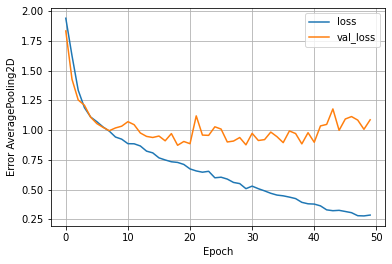

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error AveragePooling2D')
plt.legend()
plt.grid(True)

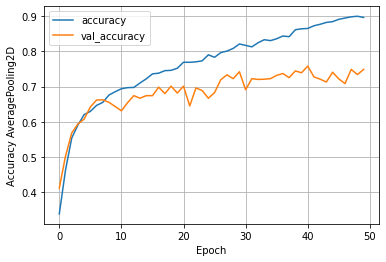

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy AveragePooling2D')
plt.legend()
plt.grid(True)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  accuracy  val_loss  val_accuracy  epoch
45  0.315390  0.890346  1.093147      0.721574     45
46  0.305306  0.893989  1.113381      0.708455     46
47  0.279924  0.897450  1.083884      0.748542     47
48  0.278158  0.899089  1.006385      0.733965     48
49  0.285307  0.895628  1.086277      0.748542     49

#### Reduce size

##### VGG19 Model with Custom Downsample Layer

In [ ]:
class MyDownSampleLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(MyDownSampleLayer, self).__init__()

    def call(self, inputs):
        shape = inputs.shape
        return tf.image.resize(inputs, (shape[1]//2, shape[2]//2))

In [ ]:
def get_vgg19_model_resize(num_classes):
    img_input = layers.Input(shape=(224,224,3))
    
    # Block 1
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(img_input)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = MyDownSampleLayer()(x)

    # Block 2
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = MyDownSampleLayer()(x)

    # Block 3
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = MyDownSampleLayer()(x)

    # Block 4
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = MyDownSampleLayer()(x)

    # Block 5
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = MyDownSampleLayer()(x)

    # Classification Block
    x = layers.Flatten()(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=num_classes, activation='softmax')(x)

    # VGG19 model
    mode = Model(inputs=img_input, outputs=x)

    return mode




In [ ]:
my_vgg19_resize = get_vgg19_model_resize(num_classes=11)
my_vgg19_resize.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 my_down_sample_layer (MyDow  (None, 112, 112, 64)     0         
 nSampleLayer)                                                   
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 128)     147584    
                                                           

##### Config and Compile Model

In [ ]:
image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = my_vgg19_resize(x)

weather_model_resize = Model(inputs=image_input, outputs=x)

In [ ]:
weather_model_resize.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model_2 (Functional)        (None, 11)                139615307 
                                                                 
Total params: 139,615,307
Trainable params: 139,615,307
Non-trainable params: 0
_________________________________________________________________


In [ ]:
weather_model_resize.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [ ]:
num_epochs = 50

checkpoint_path = "/media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather_resize.h5"
os.makedirs("/media/aivn24/partition1/Khoa/CNN2/save_model", exist_ok=True)
# os.makedirs
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 5, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)



history = weather_model_resize.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/50
172/172 [==============================] - ETA: 0s - loss: 1.9619 - accuracy: 0.3304
Epoch 00001: val_accuracy improved from -inf to 0.44315, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather_resize.h5
172/172 [==============================] - 29s 165ms/step - loss: 1.9619 - accuracy: 0.3304 - val_loss: 1.7424 - val_accuracy: 0.4431
Epoch 2/50
172/172 [==============================] - ETA: 0s - loss: 1.5532 - accuracy: 0.4872
Epoch 00002: val_accuracy improved from 0.44315 to 0.52697, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather_resize.h5
172/172 [==============================] - 29s 167ms/step - loss: 1.5532 - accuracy: 0.4872 - val_loss: 1.4602 - val_accuracy: 0.5270
Epoch 3/50
172/172 [==============================] - ETA: 0s - loss: 1.3375 - accuracy: 0.5587
Epoch 00003: val_accuracy improved from 0.52697 to 0.55758, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather_resi

172/172 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.7880
Epoch 00026: val_accuracy did not improve from 0.71064
172/172 [==============================] - 25s 147ms/step - loss: 0.6033 - accuracy: 0.7880 - val_loss: 1.1010 - val_accuracy: 0.6603
Epoch 27/50
172/172 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7931
Epoch 00027: val_accuracy did not improve from 0.71064
172/172 [==============================] - 25s 147ms/step - loss: 0.5984 - accuracy: 0.7931 - val_loss: 0.9535 - val_accuracy: 0.6713
Epoch 28/50
172/172 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.7978
Epoch 00028: val_accuracy did not improve from 0.71064
172/172 [==============================] - 25s 147ms/step - loss: 0.5687 - accuracy: 0.7978 - val_loss: 0.9051 - val_accuracy: 0.7041
Epoch 29/50
172/172 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.8067
Epoch 00029: val_accuracy did not improve from 0.71064
17

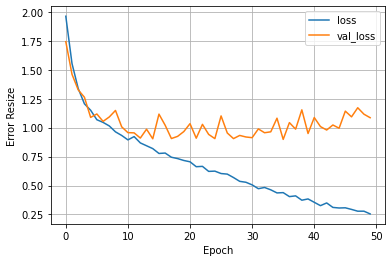

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error Resize')
plt.legend()
plt.grid(True)

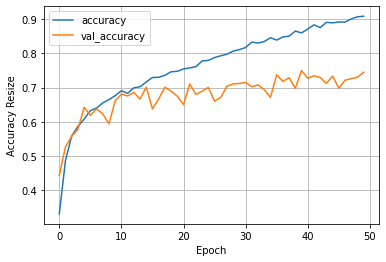

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Resize')
plt.legend()
plt.grid(True)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  accuracy  val_loss  val_accuracy  epoch
45  0.307404  0.891985  1.142384      0.698251     45
46  0.293532  0.891621  1.093019      0.721574     46
47  0.278155  0.900911  1.171603      0.725947     47
48  0.278211  0.907104  1.115956      0.730321     48
49  0.254629  0.908743  1.085505      0.744898     49

#### Conv2D with Strides=2

##### VGG19 Model with Custom Downsample Layer 

In [ ]:
def get_vgg19_model_convStride2(num_classes):
    img_input = layers.Input(shape=(224,224,3))
    
    # Block 1
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(img_input)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(2,2), padding='same')(x)

    # Block 2
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=(2,2), padding='same')(x)

    # Block 3
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(2,2), padding='same')(x)

    # Block 4
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), 
                      activation='relu', strides=(2,2), padding='same')(x)

    # Block 5
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', strides=(2,2), padding='same')(x)

    # Classification Block
    x = layers.Flatten()(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=num_classes, activation='softmax')(x)

    # VGG19 model
    mode = Model(inputs=img_input, outputs=x)

    return mode




In [ ]:
my_vgg19_convStride2 = get_vgg19_model_convStride2(num_classes=11)
my_vgg19_convStride2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 conv2d_34 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_35 (Conv2D)          (None, 56, 56, 128)       147584    
                                                                 
 conv2d_36 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 conv2d_37 (Conv2D)          (None, 56, 56, 256)       5900

##### Config and Compile Model

In [ ]:
image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = my_vgg19_convStride2(x)

weather_model_convStride2 = Model(inputs=image_input, outputs=x)

In [ ]:
weather_model_convStride2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model_4 (Functional)        (None, 11)                139615307 
                                                                 
Total params: 139,615,307
Trainable params: 139,615,307
Non-trainable params: 0
_________________________________________________________________


In [ ]:
weather_model_convStride2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [ ]:
num_epochs = 50

checkpoint_path = "/media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather_convStride2.h5"
os.makedirs("/media/aivn24/partition1/Khoa/CNN2/save_model", exist_ok=True)
# os.makedirs
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 5, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)



history = weather_model_convStride2.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/50
172/172 [==============================] - ETA: 0s - loss: 1.9369 - accuracy: 0.3322
Epoch 00001: val_accuracy improved from -inf to 0.44534, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather_convStride2.h5
172/172 [==============================] - 25s 142ms/step - loss: 1.9369 - accuracy: 0.3322 - val_loss: 1.6278 - val_accuracy: 0.4453
Epoch 2/50
172/172 [==============================] - ETA: 0s - loss: 1.4960 - accuracy: 0.5009
Epoch 00002: val_accuracy improved from 0.44534 to 0.55248, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_weather_convStride2.h5
172/172 [==============================] - 24s 138ms/step - loss: 1.4960 - accuracy: 0.5009 - val_loss: 1.3441 - val_accuracy: 0.5525
Epoch 3/50
172/172 [==============================] - ETA: 0s - loss: 1.2721 - accuracy: 0.5659
Epoch 00003: val_accuracy improved from 0.55248 to 0.56706, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/base_vgg19_we

Epoch 26/50
172/172 [==============================] - ETA: 0s - loss: 0.5932 - accuracy: 0.7909
Epoch 00026: val_accuracy did not improve from 0.72376
172/172 [==============================] - 21s 120ms/step - loss: 0.5932 - accuracy: 0.7909 - val_loss: 0.8947 - val_accuracy: 0.7070
Epoch 27/50
172/172 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.7842
Epoch 00027: val_accuracy did not improve from 0.72376
172/172 [==============================] - 21s 121ms/step - loss: 0.6023 - accuracy: 0.7842 - val_loss: 0.8926 - val_accuracy: 0.7099
Epoch 28/50
172/172 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7918
Epoch 00028: val_accuracy did not improve from 0.72376
172/172 [==============================] - 21s 121ms/step - loss: 0.5809 - accuracy: 0.7918 - val_loss: 0.9122 - val_accuracy: 0.7121
Epoch 29/50
172/172 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.8091
Epoch 00029: val_accuracy improved from 0.723

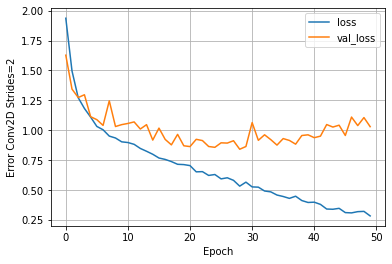

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error Conv2D Strides=2')
plt.legend()
plt.grid(True)

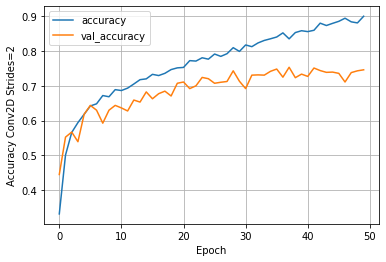

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Conv2D Strides=2')
plt.legend()
plt.grid(True)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  accuracy  val_loss  val_accuracy  epoch
45  0.311083  0.884699  0.956232      0.735423     45
46  0.308661  0.893625  1.110137      0.710641     46
47  0.318966  0.883242  1.038998      0.737609     47
48  0.321224  0.880146  1.105966      0.742711     48
49  0.283303  0.899271  1.029887      0.745627     49

## EX3: Custom CNN model for traffic signs classification:

### Prepare Weather Data

#### Thống kê data

In [ ]:
!unzip -q -n /media/aivn24/partition1/Khoa/CNN2/traffic-signs-classification.zip -d /media/aivn24/partition1/Khoa/CNN2/traffic-signs-classification

In [ ]:
# list đường dẫn các file ảnh
TRAFFICSIGN_DATA_PATH = '/media/aivn24/partition1/Khoa/CNN2/traffic-signs-classification/traffic-signs-classification/myData'
path_imgs = list(glob.glob(TRAFFICSIGN_DATA_PATH+'/**/*.jpg'))


In [ ]:
# split đường dẫn các file để lấy label cho ảnh và tao thành dataframe để  thống kê
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path Labels
0  /media/aivn24/partition1/Khoa/CNN2/traffic-sig...      4
1  /media/aivn24/partition1/Khoa/CNN2/traffic-sig...      5
2  /media/aivn24/partition1/Khoa/CNN2/traffic-sig...      3
3  /media/aivn24/partition1/Khoa/CNN2/traffic-sig...      3
4  /media/aivn24/partition1/Khoa/CNN2/traffic-sig...     38

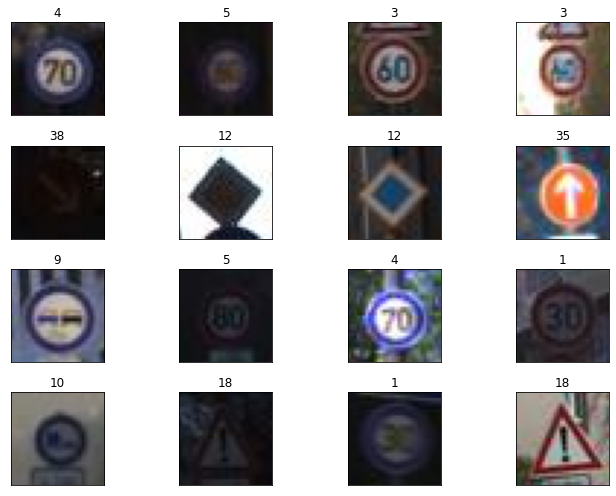

In [ ]:
# vẽ các ảnh tương ứng với label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

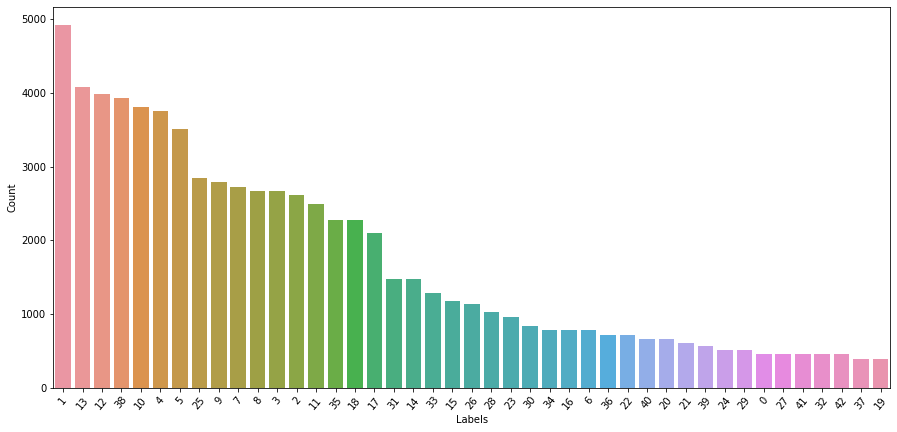

In [ ]:
# Thống kê số lượng ảnh cho từng label 
plt.figure(figsize=(15,7))
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

#### Split Tran Validation data

In [ ]:
batch_size = 1024
img_height = 32
img_width = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=TRAFFICSIGN_DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 73139 files belonging to 43 classes.
Using 58512 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=TRAFFICSIGN_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 73139 files belonging to 43 classes.
Using 14627 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


#### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(scale=1./255, offset=0.0),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(1024, 32, 32, 3)
(1024,)


In [ ]:
labels_batch

<tf.Tensor: shape=(1024,), dtype=int32, numpy=array([10, 10, 21, ...,  9,  9,  5], dtype=int32)>

### Training

#### Model

In [ ]:
def get_trafficsign_model(num_classes):
    img_input = layers.Input(shape=(32,32,3))
    
    # Block 1
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(img_input)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 2
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Block 3
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Classification Block
    x = layers.Flatten()(x)
    x = layers.Dense(units=1024, activation='relu')(x)
    x = layers.Dense(units=1024, activation='relu')(x)
    x = layers.Dense(units=num_classes, activation='softmax')(x)

    # VGG19 model
    mode = Model(inputs=img_input, outputs=x)

    return mode




In [ ]:
my_trafficsign_model = get_trafficsign_model(num_classes=43)
my_trafficsign_model.summary()

NameError: ignored

#### Config and Compile Model

In [ ]:
image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = my_trafficsign_model(x)

trafficsign_classification_model = Model(inputs=image_input, outputs=x)

NameError: ignored

In [ ]:
trafficsign_classification_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 model_6 (Functional)        (None, 43)                7614571   
                                                                 
Total params: 7,614,571
Trainable params: 7,614,571
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trafficsign_classification_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [ ]:
num_epochs = 50

checkpoint_path = "/media/aivn24/partition1/Khoa/CNN2/save_model/custom_trafficsign_model.h5"
os.makedirs("/media/aivn24/partition1/Khoa/CNN2/save_model", exist_ok=True)
# os.makedirs
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 5, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)



history = trafficsign_classification_model.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 3.5440 - accuracy: 0.0662
Epoch 00001: val_accuracy improved from -inf to 0.09387, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/custom_trafficsign_model.h5
58/58 [==============================] - 6s 79ms/step - loss: 3.5440 - accuracy: 0.0662 - val_loss: 3.4364 - val_accuracy: 0.0939
Epoch 2/50
57/58 [============================>.] - ETA: 0s - loss: 3.2075 - accuracy: 0.1353
Epoch 00002: val_accuracy improved from 0.09387 to 0.16654, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/custom_trafficsign_model.h5
58/58 [==============================] - 4s 72ms/step - loss: 3.2065 - accuracy: 0.1356 - val_loss: 3.0713 - val_accuracy: 0.1665
Epoch 3/50
57/58 [============================>.] - ETA: 0s - loss: 2.7235 - accuracy: 0.2263
Epoch 00003: val_accuracy improved from 0.16654 to 0.29972, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/custom_trafficsign_model.h5
58/58 [====

57/58 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.8508
Epoch 00025: val_accuracy did not improve from 0.84659
58/58 [==============================] - 4s 68ms/step - loss: 0.4638 - accuracy: 0.8508 - val_loss: 0.5831 - val_accuracy: 0.8148
Epoch 26/50
57/58 [============================>.] - ETA: 0s - loss: 0.4667 - accuracy: 0.8480
Epoch 00026: val_accuracy did not improve from 0.84659
58/58 [==============================] - 4s 68ms/step - loss: 0.4665 - accuracy: 0.8480 - val_loss: 0.5482 - val_accuracy: 0.8235
Epoch 27/50
57/58 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.8605
Epoch 00027: val_accuracy improved from 0.84659 to 0.86012, saving model to /media/aivn24/partition1/Khoa/CNN2/save_model/custom_trafficsign_model.h5
58/58 [==============================] - 4s 73ms/step - loss: 0.4355 - accuracy: 0.8604 - val_loss: 0.4185 - val_accuracy: 0.8601
Epoch 28/50
57/58 [============================>.] - ETA: 0s - loss: 0.4540 -

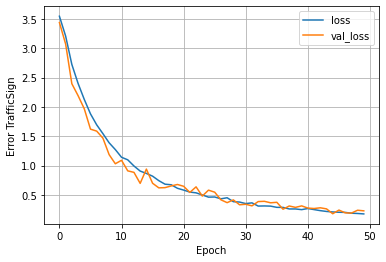

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error TrafficSign')
plt.legend()
plt.grid(True)

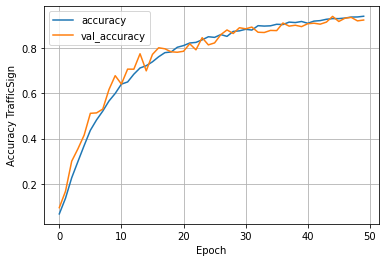

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy TrafficSign')
plt.legend()
plt.grid(True)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  accuracy  val_loss  val_accuracy  epoch
45  0.206580  0.931091  0.243859      0.918438     45
46  0.204295  0.933638  0.196819      0.933069     46
47  0.190620  0.937996  0.191781      0.936624     47
48  0.185913  0.938440  0.241021      0.921173     48
49  0.178326  0.941619  0.230718      0.924797     49

## Ex4: Denoise Image

### Prepare Denoising Dataset

In [ ]:
!unzip -q -n /media/aivn24/partition1/Khoa/CNN2/K_LHR_image.zip -d /media/aivn24/partition1/Khoa/CNN2/K_LHR_image

#### Split Train - Validation Data

In [ ]:
CD_TRAIN_DATA_PATH = '/media/aivn24/partition1/Khoa/CNN2/K_LHR_image/K_LHR_image/train'
CD_VAL_DATA_PATH = '/media/aivn24/partition1/Khoa/CNN2/K_LHR_image/K_LHR_image/val'

In [ ]:
BUFFER_SIZE = 32*10
BATCH_SIZE  = 32
IMG_WIDTH   = 256
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
        
    input_image  = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    target_image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    input_image  = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)

    noise_level = 30.0
    noise = tf.random.normal((IMG_HEIGHT, IMG_WIDTH, 3))*noise_level    
    input_image = input_image + noise  

    # clip
    input_image = tf.clip_by_value(input_image, 0.0, 255.0)

    # normalize
    input_image  = input_image / 255.0
    target_image = target_image / 255.0

    return input_image, target_image

(256, 256, 3)
(256, 256, 3)


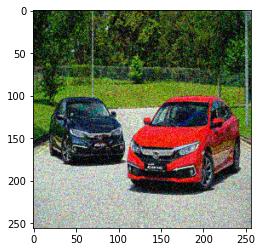

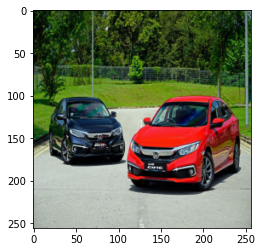

In [ ]:
input_image, target_image = load(CD_TRAIN_DATA_PATH+"/0.png")
print(input_image.shape)
print(target_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_image)
plt.figure()
plt.imshow(target_image)

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(CD_TRAIN_DATA_PATH+'/*.png')
train_dataset = train_dataset.map(load, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
#train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)

# val_dataset
val_dataset = tf.data.Dataset.list_files(CD_VAL_DATA_PATH+'/*.png')
val_dataset = val_dataset.map(load)
val_dataset = val_dataset.batch(BATCH_SIZE)
#val_dataset = val_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [ ]:
for X,Y in train_dataset:
  print(X.shape)
  print(Y.shape)
  break

(32, 256, 256, 3)
(32, 256, 256, 3)


In [ ]:
def get_denoise_model():
    input_image = layers.Input(shape=(256,256,3))

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same')(input_image)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(filters=3, kernel_size=1, activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=input_image, outputs=x)
    return model

In [ ]:
my_denoise_model = get_denoise_model()
my_denoise_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_56 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_57 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 64)      0         
                                                                 
 conv2d_58 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256, 256, 128)     0   

In [ ]:
# train
optimizer = tf.keras.optimizers.Adam(0.0001)
my_denoise_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mean_absolute_error'])
history_data = my_denoise_model.fit(train_dataset,
                         epochs=50)

Epoch 1/50
22/22 [==============================] - 6s 180ms/step - loss: 0.2497 - mean_absolute_error: 0.2497
Epoch 2/50
22/22 [==============================] - 3s 142ms/step - loss: 0.2286 - mean_absolute_error: 0.2286
Epoch 3/50
22/22 [==============================] - 3s 143ms/step - loss: 0.1697 - mean_absolute_error: 0.1697
Epoch 4/50
22/22 [==============================] - 3s 146ms/step - loss: 0.0984 - mean_absolute_error: 0.0984
Epoch 5/50
22/22 [==============================] - 3s 145ms/step - loss: 0.0766 - mean_absolute_error: 0.0766
Epoch 6/50
22/22 [==============================] - 3s 145ms/step - loss: 0.0634 - mean_absolute_error: 0.0634
Epoch 7/50
22/22 [==============================] - 3s 146ms/step - loss: 0.0562 - mean_absolute_error: 0.0562
Epoch 8/50
22/22 [==============================] - 3s 148ms/step - loss: 0.0516 - mean_absolute_error: 0.0516
Epoch 9/50
22/22 [==============================] - 3s 148ms/step - loss: 0.0481 - mean_absolute_error: 0.0481
E

In [ ]:
my_denoise_model.save("denoising_model.h5")

In [ ]:
my_denoise_model = tf.keras.models.load_model("denoising_model.h5")

In [ ]:
for X,Y in train_dataset:
  Y_hat = my_denoise_model.predict(X)

  plt.figure(figsize=(15,10))
    
  display_list = [X[0], Y[0], Y_hat[0]]
  title = ['Input(ảnh thêm nhiễu)', 'Real(ảnh gốc)', 'Predicted']    

  for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i], fontsize=17)
      plt.imshow(display_list[i])
      plt.axis('off')
  plt.show() 
  break

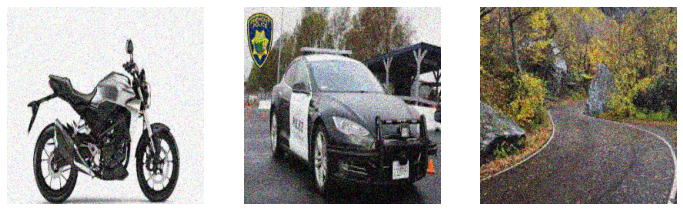

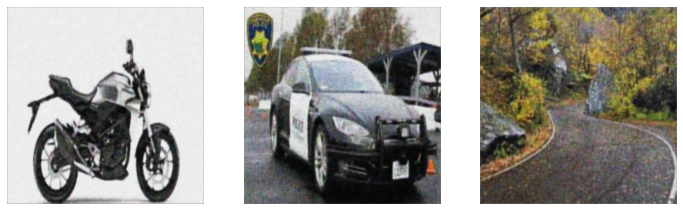

In [ ]:
for X,_ in train_dataset:
  Y_hat = my_denoise_model.predict(X)

  columns = 3
  rows = 1

  fig = plt.figure(figsize=(12,8))  
  for i in range(1, columns*rows +1):
      img = X[i].numpy().reshape(256,256,3)
      fig.add_subplot(rows, columns, i)
      
      plt.axis('off')
      plt.imshow(img)

  fig = plt.figure(figsize=(12,8))  
  for i in range(1, columns*rows +1):
      img = Y_hat[i].reshape(256,256,3)
      fig.add_subplot(rows, columns, i)
      
      plt.axis('off')
      plt.imshow(img)

  break

## Ex5: Super Resolution

In [ ]:
!unzip -q -n /media/aivn24/partition1/Khoa/CNN2/K_LHR_image.zip -d /media/aivn24/partition1/Khoa/CNN2/K_LHR_image

### Prepare Super Resolution Dataset

In [ ]:
LHR_TRAIN_DATA_PATH = '/media/aivn24/partition1/Khoa/CNN2/K_LHR_image/K_LHR_image/train'
LHR_VAL_DATA_PATH = '/media/aivn24/partition1/Khoa/CNN2/K_LHR_image/K_LHR_image/val'


#### Split Tran Validation data

In [ ]:
batch_size = 32
img_height = 64
img_width = 64
buffer_size = batch_size*10

In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)
        
    input_image  = tf.image.resize(image, (img_height, img_width))
    target_image = image
    
    input_image  = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)

    # # clip
    # input_image = tf.clip_by_value(input_image, 0.0, 255.0)

    # normalize
    input_image  = input_image / 255.0
    target_image = target_image / 255.0

    return input_image, target_image

(64, 64, 3)
(256, 256, 3)


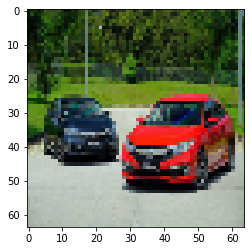

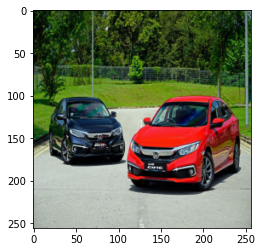

In [ ]:
input_image, target_image = load(LHR_TRAIN_DATA_PATH+'/0.png')
print(input_image.shape)
print(target_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_image)
plt.figure()
plt.imshow(target_image)

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(LHR_TRAIN_DATA_PATH + '/*.png')
train_dataset = train_dataset.map(load, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size)
#train_dataset = train_dataset.prefetch(buffer_size=buffer_size)

# val_dataset
val_dataset = tf.data.Dataset.list_files(LHR_VAL_DATA_PATH + '/*.png')
val_dataset = val_dataset.map(load)
val_dataset = val_dataset.batch(batch_size)
#val_dataset = val_dataset.prefetch(buffer_size=buffer_size)

In [ ]:
for X,Y in train_dataset:
  print(X.shape)
  print(Y.shape)
  break

(32, 64, 64, 3)
(32, 256, 256, 3)


### Training

#### Model

In [ ]:
class MyUpSampleLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(MyUpSampleLayer, self).__init__()

    def call(self, inputs):
        shape = inputs.shape
        return tf.image.resize(inputs, (shape[1]*2, shape[2]*2))

In [ ]:
def get_super_res_model():
    img_input = layers.Input(shape=(img_height,img_width,3))
    
    # Block 1
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(img_input)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Block 2
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    # Block 3
    x = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    

    # Block 4
    x = MyUpSampleLayer()(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Block 5
    x = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    # Block 6
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)


    # Final Block
    x = MyUpSampleLayer()(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters=3, kernel_size=(1,1), activation='sigmoid', padding='same')(x)
   

    mode = Model(inputs=img_input, outputs=x)

    return mode

In [ ]:
my_super_res_model = get_super_res_model()
my_super_res_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_63 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0   

#### Config and Compile Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001)
my_super_res_model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.MeanAbsoluteError(), 
                      metrics=['mean_absolute_error'])


In [ ]:
num_epochs = 50

checkpoint_path = "/media/aivn24/partition1/Khoa/CNN2/save_model/super_resolution_model.h5"
os.makedirs("/media/aivn24/partition1/Khoa/CNN2/save_model", exist_ok=True)
# # os.makedirs
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
# learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
#                                             patience = 5, 
#                                             verbose=1,
#                                             factor=0.5, 
#                                             min_lr=0.00001)



history = my_super_res_model.fit(train_dataset,
                                epochs = num_epochs,
                                validation_data = val_dataset,
                                callbacks=[model_checkpoint])

Epoch 1/50
22/22 [==============================] - 9s 299ms/step - loss: 0.2459 - mean_absolute_error: 0.2459 - val_loss: 0.2290 - val_mean_absolute_error: 0.2290
Epoch 2/50
22/22 [==============================] - 4s 198ms/step - loss: 0.1847 - mean_absolute_error: 0.1847 - val_loss: 0.1407 - val_mean_absolute_error: 0.1407
Epoch 3/50
22/22 [==============================] - 4s 198ms/step - loss: 0.1098 - mean_absolute_error: 0.1098 - val_loss: 0.1049 - val_mean_absolute_error: 0.1049
Epoch 4/50
22/22 [==============================] - 4s 199ms/step - loss: 0.0910 - mean_absolute_error: 0.0910 - val_loss: 0.0894 - val_mean_absolute_error: 0.0894
Epoch 5/50
22/22 [==============================] - 4s 200ms/step - loss: 0.0773 - mean_absolute_error: 0.0773 - val_loss: 0.0742 - val_mean_absolute_error: 0.0742
Epoch 6/50
22/22 [==============================] - 4s 202ms/step - loss: 0.0703 - mean_absolute_error: 0.0703 - val_loss: 0.0743 - val_mean_absolute_error: 0.0743
Epoch 7/50
22/22

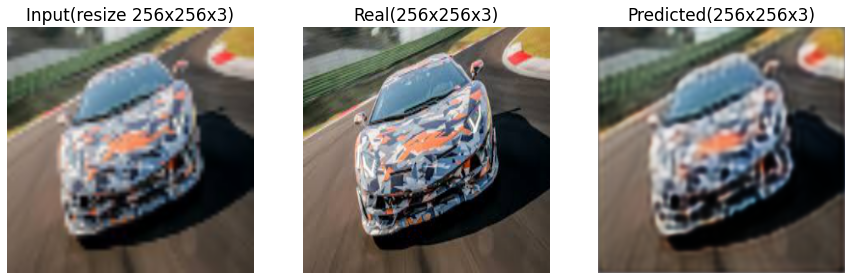

In [ ]:
for X,Y in train_dataset:
  Y_hat = my_super_res_model.predict(X)

  plt.figure(figsize=(15,15))
    
  display_list = [tf.image.resize(X[0], (256,256)), Y[0], Y_hat[0]]
  title = ['Input(resize 256x256x3)', 'Real(256x256x3)', 'Predicted(256x256x3)']    

  for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i], fontsize=17)
      plt.imshow(display_list[i])
      plt.axis('off')
  plt.show() 
  break

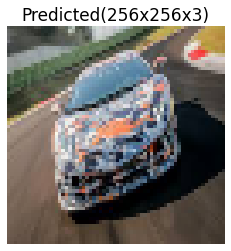

In [ ]:
plt.title(title[i], fontsize=17)
plt.imshow(X[0])
plt.axis('off')
plt.show() 

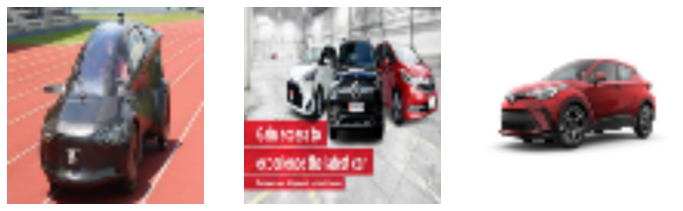

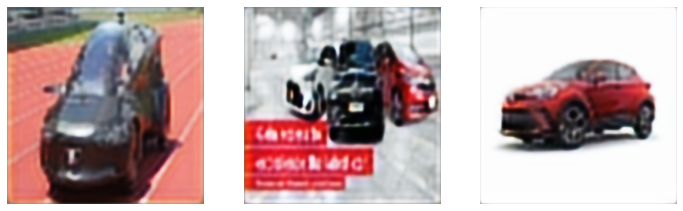

In [ ]:
for X,_ in train_dataset:
  Y_hat = my_super_res_model.predict(X)

  columns = 3
  rows = 1

  fig = plt.figure(figsize=(12,8))  
  for i in range(1, columns*rows +1):
      img = tf.image.resize(X[i], (256,256)).numpy().reshape(256,256,3)
      fig.add_subplot(rows, columns, i)
      
      plt.axis('off')
      plt.imshow(img)

  fig = plt.figure(figsize=(12,8))  
  for i in range(1, columns*rows +1):
      img = Y_hat[i].reshape(256,256,3)
      fig.add_subplot(rows, columns, i)
      
      plt.axis('off')
      plt.imshow(img)

  break